Mean Absolute Error (MAE): 0.5995
Mean Squared Error (MSE): 0.6147
Root Mean Squared Error (RMSE): 0.7840
R² Score: 0.3913

Bootstrap Results (mean ± std):
MAE  = 0.6014 ± 0.0285
MSE  = 0.6178 ± 0.0972
R²   = 0.3905 ± 0.0634

Outlier indices (threshold=4, method=zscore): [203, 215]
Saved 2 outliers to 'mers_predicted_true_xg_outliers.csv'


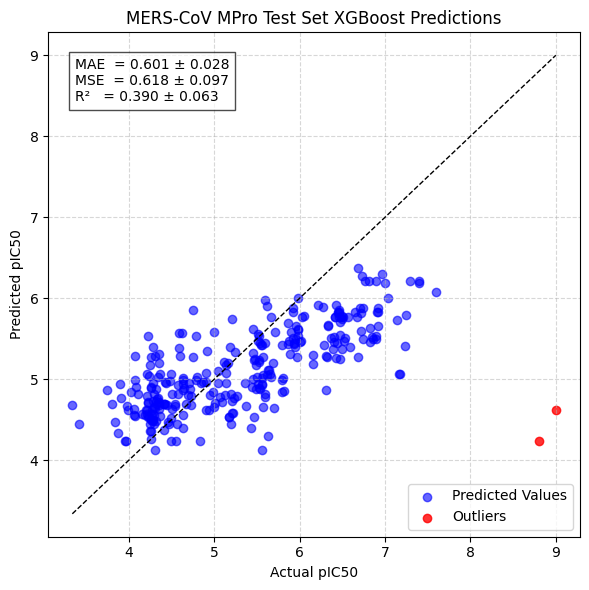

In [16]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- Outlier detection function ---
def detect_outliers(data, method='zscore', threshold=3.0):
    data = np.array(data)

    if method == 'iqr':
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = (data < lower_bound) | (data > upper_bound)

    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(data))
        outliers = z_scores > threshold

    elif method == 'modified_zscore':
        median = np.median(data)
        mad = np.median(np.abs(data - median))
        modified_z_scores = 0.6745 * (data - median) / mad
        outliers = np.abs(modified_z_scores) > threshold

    else:
        raise ValueError("Invalid method. Choose 'iqr', 'zscore', or 'modified_zscore'.")
    
    return outliers

# --- Load CSV ---
df = pd.read_csv("mers_predicted_true_xg.csv")

y_true = df["pIC50 (MERS-CoV Mpro)"].values
y_pred = df["predicted MERS"].values

# --- Metrics ---
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# --- Bootstrapping for error bars (MSE instead of RMSE) ---
def bootstrap_metrics(y_true, y_pred, n_bootstrap=1000, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(y_true)
    mae_list, mse_list, r2_list = [], [], []
    
    for _ in range(n_bootstrap):
        idx = rng.choice(n, n, replace=True)
        y_true_bs = y_true[idx]
        y_pred_bs = y_pred[idx]
        
        mae_list.append(mean_absolute_error(y_true_bs, y_pred_bs))
        mse_list.append(mean_squared_error(y_true_bs, y_pred_bs))  # MSE here
        r2_list.append(r2_score(y_true_bs, y_pred_bs))
    
    return {
        "mae": (np.mean(mae_list), np.std(mae_list)),
        "mse": (np.mean(mse_list), np.std(mse_list)),  # changed from rmse
        "r2": (np.mean(r2_list), np.std(r2_list))
    }

bootstrap_results = bootstrap_metrics(y_true, y_pred)

print("\nBootstrap Results (mean ± std):")
print(f"MAE  = {bootstrap_results['mae'][0]:.4f} ± {bootstrap_results['mae'][1]:.4f}")
print(f"MSE  = {bootstrap_results['mse'][0]:.4f} ± {bootstrap_results['mse'][1]:.4f}")
print(f"R²   = {bootstrap_results['r2'][0]:.4f} ± {bootstrap_results['r2'][1]:.4f}")

# --- Outlier detection using Z-score method ---
errors = np.abs(y_true - y_pred)
outlier_mask = detect_outliers(errors, method='zscore', threshold=4)

# Show outlier indices
outlier_indices = df.index[outlier_mask].tolist()
print(f"\nOutlier indices (threshold=4, method=zscore): {outlier_indices}")

outlier_df = df.loc[outlier_mask]
outlier_df.to_csv("mers_predicted_true_xg_outliers.csv", index=False)
print(f"Saved {len(outlier_df)} outliers to 'mers_predicted_true_xg_outliers.csv'")

# --- Plot ---
plt.figure(figsize=(6, 6))

# Inliers (blue)
plt.scatter(y_true[~outlier_mask], y_pred[~outlier_mask], 
            color="blue", alpha=0.6, label="Predicted Values")

# Outliers (red, with labels)
plt.scatter(y_true[outlier_mask], y_pred[outlier_mask], 
            color="red", alpha=0.8, label="Outliers")

# Perfect correlation line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

plt.xlabel("Actual pIC50")
plt.ylabel("Predicted pIC50")
plt.title("MERS-CoV MPro Test Set XGBoost Predictions")

# Put bootstrap metrics in the plot
metrics_text = (
    f"MAE  = {bootstrap_results['mae'][0]:.3f} ± {bootstrap_results['mae'][1]:.3f}\n"
    f"MSE  = {bootstrap_results['mse'][0]:.3f} ± {bootstrap_results['mse'][1]:.3f}\n"
    f"R²   = {bootstrap_results['r2'][0]:.3f} ± {bootstrap_results['r2'][1]:.3f}"
)
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(facecolor="white", alpha=0.7))

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("mers_xg_test_pred_boot.pdf")
plt.show()


Mean Absolute Error (MAE): 0.6549
Mean Squared Error (MSE): 0.7124
Root Mean Squared Error (RMSE): 0.8440
R² Score: 0.2945

Bootstrap Results (mean ± std):
MAE  = 0.6568 ± 0.0299
MSE  = 0.7157 ± 0.0950
R²   = 0.2930 ± 0.0549
Saved 2 outliers to 'mers_predicted_true_rf_outliers.csv'


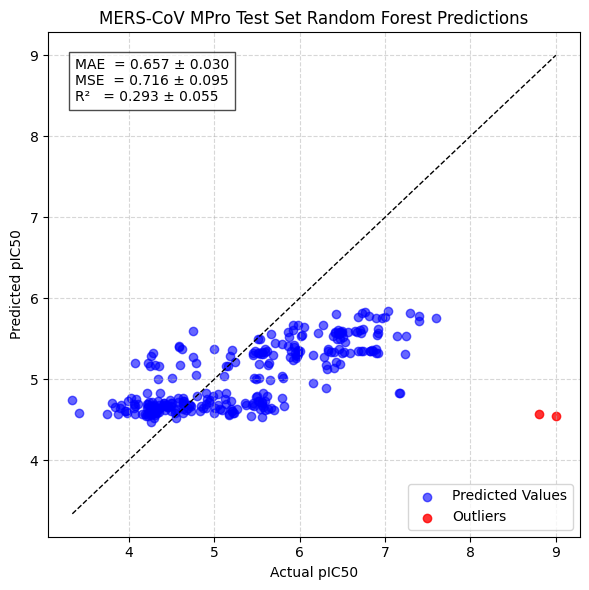

In [15]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# --- Load CSV ---
df = pd.read_csv("mers_predicted_true_rf.csv")

y_true = df["pIC50 (MERS-CoV Mpro)"].values
y_pred = df["predicted MERS"].values

# --- Metrics ---
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# --- Bootstrapping for error bars ---
def bootstrap_metrics(y_true, y_pred, n_bootstrap=1000, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(y_true)
    mae_list, mse_list, r2_list = [], [], []
    
    for _ in range(n_bootstrap):
        idx = rng.choice(n, n, replace=True)
        y_true_bs = y_true[idx]
        y_pred_bs = y_pred[idx]
        
        mae_list.append(mean_absolute_error(y_true_bs, y_pred_bs))
        mse_list.append(mean_squared_error(y_true_bs, y_pred_bs))
        r2_list.append(r2_score(y_true_bs, y_pred_bs))
    
    return {
        "mae": (np.mean(mae_list), np.std(mae_list)),
        "mse": (np.mean(mse_list), np.std(mse_list)),
        "r2": (np.mean(r2_list), np.std(r2_list))
    }

bootstrap_results = bootstrap_metrics(y_true, y_pred)

print("\nBootstrap Results (mean ± std):")
print(f"MAE  = {bootstrap_results['mae'][0]:.4f} ± {bootstrap_results['mae'][1]:.4f}")
print(f"MSE  = {bootstrap_results['mse'][0]:.4f} ± {bootstrap_results['mse'][1]:.4f}")
print(f"R²   = {bootstrap_results['r2'][0]:.4f} ± {bootstrap_results['r2'][1]:.4f}")

# --- Identify outliers ---
threshold = 2.5
errors = np.abs(y_true - y_pred)
outlier_mask = errors > threshold

outlier_df = df.loc[outlier_mask]
outlier_df.to_csv("mers_predicted_true_rf_outliers.csv", index=False)
print(f"Saved {len(outlier_df)} outliers to 'mers_predicted_true_rf_outliers.csv'")

# --- Plot ---
plt.figure(figsize=(6, 6))

# Inliers (blue)
plt.scatter(y_true[~outlier_mask], y_pred[~outlier_mask], 
            color="blue", alpha=0.6, label="Predicted Values")

# Outliers (red)
plt.scatter(y_true[outlier_mask], y_pred[outlier_mask], 
            color="red", alpha=0.8, label="Outliers")

# Perfect correlation line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

plt.xlabel("Actual pIC50")
plt.ylabel("Predicted pIC50")
plt.title("MERS-CoV MPro Test Set Random Forest Predictions")

# Add bootstrap metrics text
metrics_text = (
    f"MAE  = {bootstrap_results['mae'][0]:.3f} ± {bootstrap_results['mae'][1]:.3f}\n"
    f"MSE  = {bootstrap_results['mse'][0]:.3f} ± {bootstrap_results['mse'][1]:.3f}\n"
    f"R²   = {bootstrap_results['r2'][0]:.3f} ± {bootstrap_results['r2'][1]:.3f}"
)
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(facecolor="white", alpha=0.7))

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("mers_rf_test_pred_boot.pdf")
plt.show()


Mean Absolute Error (MAE): 0.6139
Mean Squared Error (MSE): 0.6757
Root Mean Squared Error (RMSE): 0.8220
R² Score: 0.6197

Bootstrap Results (mean ± std):
MAE  = 0.6130 ± 0.0330
MSE  = 0.6730 ± 0.0700
R²   = 0.6195 ± 0.0373
Outlier indices (threshold=4, method=zscore): []
Saved 0 outliers to 'sars_xg_pred_outliers.csv'


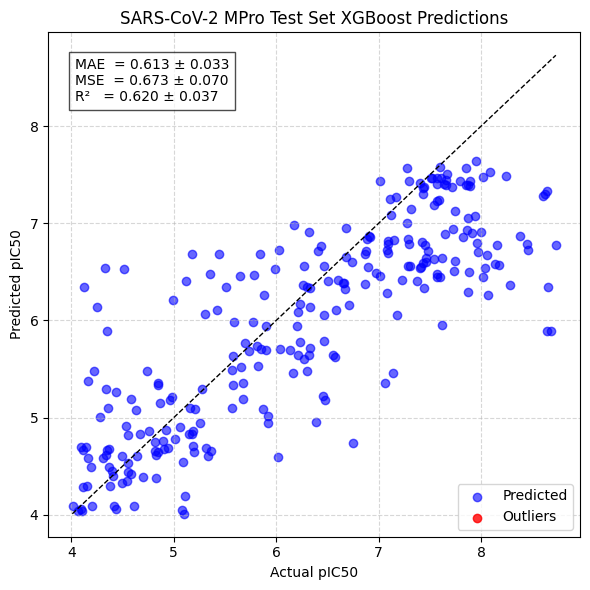

In [14]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- Outlier detection function ---
def detect_outliers(data, method='zscore', threshold=3.0):
    data = np.array(data)

    if method == 'iqr':
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = (data < lower_bound) | (data > upper_bound)

    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(data))
        outliers = z_scores > threshold

    elif method == 'modified_zscore':
        median = np.median(data)
        mad = np.median(np.abs(data - median))
        modified_z_scores = 0.6745 * (data - median) / mad
        outliers = np.abs(modified_z_scores) > threshold

    else:
        raise ValueError("Invalid method. Choose 'iqr', 'zscore', or 'modified_zscore'.")
    
    return outliers

# --- Load CSV ---
df = pd.read_csv("sars_predicted_true.csv")

y_true = df["pIC50 (SARS-CoV-2 Mpro)"].values
y_pred = df["predicted SARS"].values

# --- Metrics ---
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# --- Bootstrapping for error bars ---
def bootstrap_metrics(y_true, y_pred, n_bootstrap=1000, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(y_true)
    mae_list, mse_list, r2_list = [], [], []
    
    for _ in range(n_bootstrap):
        idx = rng.choice(n, n, replace=True)
        y_true_bs = y_true[idx]
        y_pred_bs = y_pred[idx]
        
        mae_list.append(mean_absolute_error(y_true_bs, y_pred_bs))
        mse_list.append(mean_squared_error(y_true_bs, y_pred_bs))
        r2_list.append(r2_score(y_true_bs, y_pred_bs))
    
    return {
        "mae": (np.mean(mae_list), np.std(mae_list)),
        "mse": (np.mean(mse_list), np.std(mse_list)),
        "r2": (np.mean(r2_list), np.std(r2_list))
    }

bootstrap_results = bootstrap_metrics(y_true, y_pred)

print("\nBootstrap Results (mean ± std):")
print(f"MAE  = {bootstrap_results['mae'][0]:.4f} ± {bootstrap_results['mae'][1]:.4f}")
print(f"MSE  = {bootstrap_results['mse'][0]:.4f} ± {bootstrap_results['mse'][1]:.4f}")
print(f"R²   = {bootstrap_results['r2'][0]:.4f} ± {bootstrap_results['r2'][1]:.4f}")

# --- Outlier detection using Z-score method ---
errors = np.abs(y_true - y_pred)
outlier_mask = detect_outliers(errors, method='zscore', threshold=4)

# Show outlier indices
outlier_indices = df.index[outlier_mask].tolist()
print(f"Outlier indices (threshold=4, method=zscore): {outlier_indices}")

outlier_df = df.loc[outlier_mask]
outlier_df.to_csv("sars_xg_pred_outliers.csv", index=False)
print(f"Saved {len(outlier_df)} outliers to 'sars_xg_pred_outliers.csv'")

# --- Plot ---
plt.figure(figsize=(6, 6))

# Inliers (blue)
plt.scatter(y_true[~outlier_mask], y_pred[~outlier_mask], 
            color="blue", alpha=0.6, label="Predicted")

# Outliers (red)
plt.scatter(y_true[outlier_mask], y_pred[outlier_mask], 
            color="red", alpha=0.8, label="Outliers")

# Perfect correlation line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

plt.xlabel("Actual pIC50")
plt.ylabel("Predicted pIC50")
plt.title("SARS-CoV-2 MPro Test Set XGBoost Predictions")

# Add bootstrap metrics text
metrics_text = (
    f"MAE  = {bootstrap_results['mae'][0]:.3f} ± {bootstrap_results['mae'][1]:.3f}\n"
    f"MSE  = {bootstrap_results['mse'][0]:.3f} ± {bootstrap_results['mse'][1]:.3f}\n"
    f"R²   = {bootstrap_results['r2'][0]:.3f} ± {bootstrap_results['r2'][1]:.3f}"
)
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(facecolor="white", alpha=0.7))

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("sars_xg_test_pred_boot.pdf")
plt.show()


Mean Absolute Error (MAE): 0.6509
Mean Squared Error (MSE): 0.6824
Root Mean Squared Error (RMSE): 0.8261
R² Score: 0.6159

Bootstrap Results (mean ± std):
MAE  = 0.6512 ± 0.0317
MSE  = 0.6826 ± 0.0709
R²   = 0.6140 ± 0.0387
Outlier indices (threshold=4, method=zscore): [119, 124]
Saved 2 outliers to 'sars_predicted_true_rf_outliers.csv'


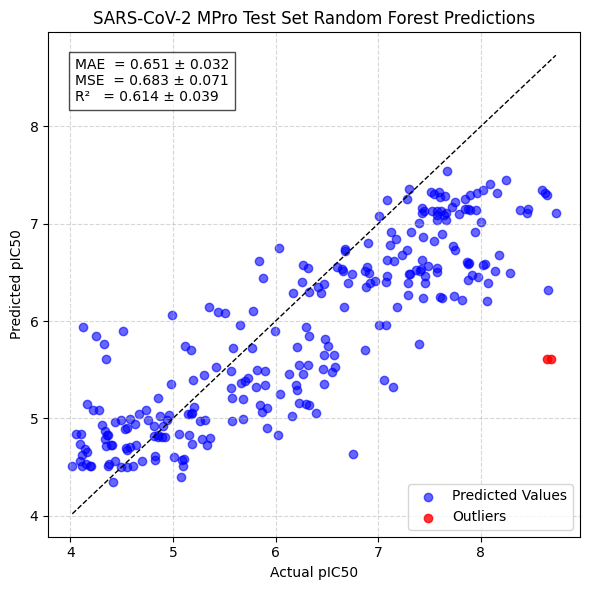

In [13]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- Outlier detection function ---
def detect_outliers(data, method='zscore', threshold=3.0):
    data = np.array(data)

    if method == 'iqr':
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = (data < lower_bound) | (data > upper_bound)

    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(data))
        outliers = z_scores > threshold

    elif method == 'modified_zscore':
        median = np.median(data)
        mad = np.median(np.abs(data - median))
        modified_z_scores = 0.6745 * (data - median) / mad
        outliers = np.abs(modified_z_scores) > threshold

    else:
        raise ValueError("Invalid method. Choose 'iqr', 'zscore', or 'modified_zscore'.")
    
    return outliers

# --- Load CSV ---
df = pd.read_csv("sars_predicted_true_rf.csv")

y_true = df["pIC50 (SARS-CoV-2 Mpro)"].values
y_pred = df["predicted SARS"].values

# --- Metrics ---
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# --- Bootstrapping for error bars ---
def bootstrap_metrics(y_true, y_pred, n_bootstrap=1000, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(y_true)
    mae_list, mse_list, r2_list = [], [], []
    
    for _ in range(n_bootstrap):
        idx = rng.choice(n, n, replace=True)
        y_true_bs = y_true[idx]
        y_pred_bs = y_pred[idx]
        
        mae_list.append(mean_absolute_error(y_true_bs, y_pred_bs))
        mse_list.append(mean_squared_error(y_true_bs, y_pred_bs))
        r2_list.append(r2_score(y_true_bs, y_pred_bs))
    
    return {
        "mae": (np.mean(mae_list), np.std(mae_list)),
        "mse": (np.mean(mse_list), np.std(mse_list)),
        "r2": (np.mean(r2_list), np.std(r2_list))
    }

bootstrap_results = bootstrap_metrics(y_true, y_pred)

print("\nBootstrap Results (mean ± std):")
print(f"MAE  = {bootstrap_results['mae'][0]:.4f} ± {bootstrap_results['mae'][1]:.4f}")
print(f"MSE  = {bootstrap_results['mse'][0]:.4f} ± {bootstrap_results['mse'][1]:.4f}")
print(f"R²   = {bootstrap_results['r2'][0]:.4f} ± {bootstrap_results['r2'][1]:.4f}")

# --- Outlier detection using Z-score method ---
errors = np.abs(y_true - y_pred)
outlier_mask = detect_outliers(errors, method='zscore', threshold=4)

# Show outlier indices
outlier_indices = df.index[outlier_mask].tolist()
print(f"Outlier indices (threshold=4, method=zscore): {outlier_indices}")

outlier_df = df.loc[outlier_mask]
outlier_df.to_csv("sars_predicted_true_rf_outliers.csv", index=False)
print(f"Saved {len(outlier_df)} outliers to 'sars_predicted_true_rf_outliers.csv'")

# --- Plot ---
plt.figure(figsize=(6, 6))

# Inliers (blue)
plt.scatter(y_true[~outlier_mask], y_pred[~outlier_mask], 
            color="blue", alpha=0.6, label="Predicted Values")

# Outliers (red)
plt.scatter(y_true[outlier_mask], y_pred[outlier_mask], 
            color="red", alpha=0.8, label="Outliers")

# Perfect correlation line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

plt.xlabel("Actual pIC50")
plt.ylabel("Predicted pIC50")
plt.title("SARS-CoV-2 MPro Test Set Random Forest Predictions")

# Add bootstrap metrics text
metrics_text = (
    f"MAE  = {bootstrap_results['mae'][0]:.3f} ± {bootstrap_results['mae'][1]:.3f}\n"
    f"MSE  = {bootstrap_results['mse'][0]:.3f} ± {bootstrap_results['mse'][1]:.3f}\n"
    f"R²   = {bootstrap_results['r2'][0]:.3f} ± {bootstrap_results['r2'][1]:.3f}"
)
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(facecolor="white", alpha=0.7))

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("sars_rf_test_pred_boot.pdf")
plt.show()


Mean Absolute Error (MAE): 0.5619
Mean Squared Error (MSE): 0.5764
Root Mean Squared Error (RMSE): 0.7592
R² Score: 0.4320

Bootstrap Results (mean ± std):
MAE  = 0.5636 ± 0.0302
MSE  = 0.5786 ± 0.1003
R²   = 0.4311 ± 0.0695
Saved 2 outliers to 'mers_predicted_true_bnn_outliers.csv'


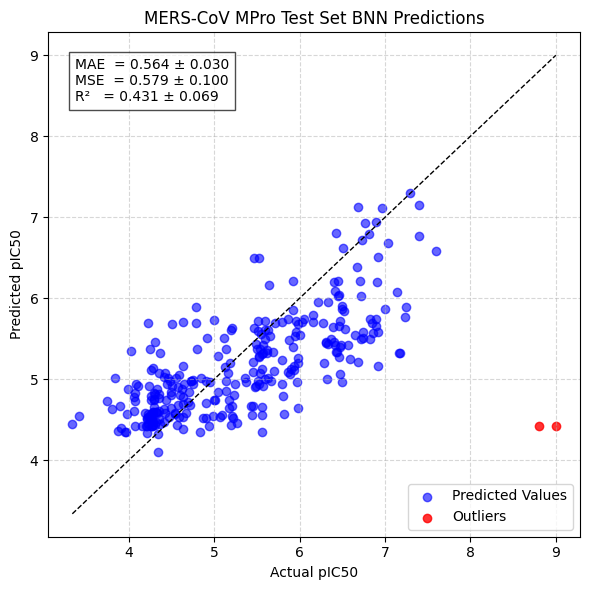

In [17]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# --- Load CSV ---
df = pd.read_csv("MERS_predictions_BNN.csv")

y_true = df["pIC50 (MERS-CoV Mpro)"].values
y_pred = df["mean_prediction"].values

# --- Metrics ---
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# --- Bootstrapping for error bars ---
def bootstrap_metrics(y_true, y_pred, n_bootstrap=1000, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(y_true)
    mae_list, mse_list, r2_list = [], [], []
    
    for _ in range(n_bootstrap):
        idx = rng.choice(n, n, replace=True)
        y_true_bs = y_true[idx]
        y_pred_bs = y_pred[idx]
        
        mae_list.append(mean_absolute_error(y_true_bs, y_pred_bs))
        mse_list.append(mean_squared_error(y_true_bs, y_pred_bs))
        r2_list.append(r2_score(y_true_bs, y_pred_bs))
    
    return {
        "mae": (np.mean(mae_list), np.std(mae_list)),
        "mse": (np.mean(mse_list), np.std(mse_list)),
        "r2": (np.mean(r2_list), np.std(r2_list))
    }

bootstrap_results = bootstrap_metrics(y_true, y_pred)

print("\nBootstrap Results (mean ± std):")
print(f"MAE  = {bootstrap_results['mae'][0]:.4f} ± {bootstrap_results['mae'][1]:.4f}")
print(f"MSE  = {bootstrap_results['mse'][0]:.4f} ± {bootstrap_results['mse'][1]:.4f}")
print(f"R²   = {bootstrap_results['r2'][0]:.4f} ± {bootstrap_results['r2'][1]:.4f}")

# --- Outlier detection ---
threshold = 2.5
errors = np.abs(y_true - y_pred)
outlier_mask = errors > threshold

outlier_df = df.loc[outlier_mask]
outlier_df.to_csv("mers_predicted_true_bnn_outliers.csv", index=False)
print(f"Saved {len(outlier_df)} outliers to 'mers_predicted_true_bnn_outliers.csv'")

# --- Plot ---
plt.figure(figsize=(6, 6))

# Inliers (blue)
plt.scatter(y_true[~outlier_mask], y_pred[~outlier_mask], 
            color="blue", alpha=0.6, label="Predicted Values")

# Outliers (red)
plt.scatter(y_true[outlier_mask], y_pred[outlier_mask], 
            color="red", alpha=0.8, label="Outliers")

# Perfect correlation line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

plt.xlabel("Actual pIC50")
plt.ylabel("Predicted pIC50")
plt.title("MERS-CoV MPro Test Set BNN Predictions")

# Add bootstrap metrics text
metrics_text = (
    f"MAE  = {bootstrap_results['mae'][0]:.3f} ± {bootstrap_results['mae'][1]:.3f}\n"
    f"MSE  = {bootstrap_results['mse'][0]:.3f} ± {bootstrap_results['mse'][1]:.3f}\n"
    f"R²   = {bootstrap_results['r2'][0]:.3f} ± {bootstrap_results['r2'][1]:.3f}"
)
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(facecolor="white", alpha=0.7))

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("mers_bnn_test_pred_boot.pdf")
plt.show()


Mean Absolute Error (MAE): 0.5619
Mean Squared Error (MSE): 0.5764
Root Mean Squared Error (RMSE): 0.7592
R² Score: 0.4320

Bootstrap Results (mean ± std):
MAE  = 0.5636 ± 0.0302
MSE  = 0.5786 ± 0.1003
RMSE = 0.7579 ± 0.0649
R²   = 0.4311 ± 0.0695
Saved 2 outliers to 'mers_predicted_true_bnn_outliers.csv'


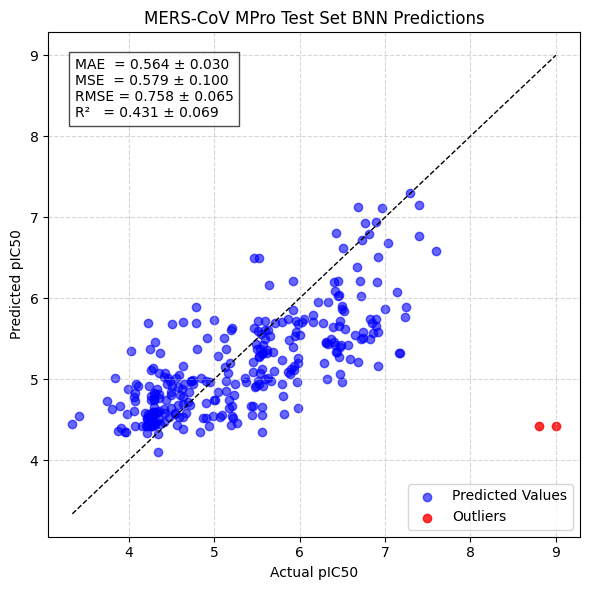

In [19]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# --- Load CSV ---
df = pd.read_csv("MERS_predictions_BNN.csv")

y_true = df["pIC50 (MERS-CoV Mpro)"].values
y_pred = df["mean_prediction"].values

# --- Metrics ---
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# --- Bootstrapping for error bars ---
def bootstrap_metrics(y_true, y_pred, n_bootstrap=1000, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(y_true)
    mae_list, mse_list, rmse_list, r2_list = [], [], [], []
    
    for _ in range(n_bootstrap):
        idx = rng.choice(n, n, replace=True)
        y_true_bs = y_true[idx]
        y_pred_bs = y_pred[idx]
        
        mae_list.append(mean_absolute_error(y_true_bs, y_pred_bs))
        mse_val = mean_squared_error(y_true_bs, y_pred_bs)
        mse_list.append(mse_val)
        rmse_list.append(np.sqrt(mse_val))
        r2_list.append(r2_score(y_true_bs, y_pred_bs))
    
    return {
        "mae": (np.mean(mae_list), np.std(mae_list)),
        "mse": (np.mean(mse_list), np.std(mse_list)),
        "rmse": (np.mean(rmse_list), np.std(rmse_list)),
        "r2": (np.mean(r2_list), np.std(r2_list))
    }

bootstrap_results = bootstrap_metrics(y_true, y_pred)

print("\nBootstrap Results (mean ± std):")
print(f"MAE  = {bootstrap_results['mae'][0]:.4f} ± {bootstrap_results['mae'][1]:.4f}")
print(f"MSE  = {bootstrap_results['mse'][0]:.4f} ± {bootstrap_results['mse'][1]:.4f}")
print(f"RMSE = {bootstrap_results['rmse'][0]:.4f} ± {bootstrap_results['rmse'][1]:.4f}")
print(f"R²   = {bootstrap_results['r2'][0]:.4f} ± {bootstrap_results['r2'][1]:.4f}")

# --- Outlier detection ---
threshold = 2.5
errors = np.abs(y_true - y_pred)
outlier_mask = errors > threshold

outlier_df = df.loc[outlier_mask]
outlier_df.to_csv("mers_predicted_true_bnn_outliers.csv", index=False)
print(f"Saved {len(outlier_df)} outliers to 'mers_predicted_true_bnn_outliers.csv'")

# --- Plot ---
plt.figure(figsize=(6, 6))

# Inliers (blue)
plt.scatter(y_true[~outlier_mask], y_pred[~outlier_mask], 
            color="blue", alpha=0.6, label="Predicted Values")

# Outliers (red)
plt.scatter(y_true[outlier_mask], y_pred[outlier_mask], 
            color="red", alpha=0.8, label="Outliers")

# Perfect correlation line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

plt.xlabel("Actual pIC50")
plt.ylabel("Predicted pIC50")
plt.title("MERS-CoV MPro Test Set BNN Predictions")

# Add bootstrap metrics text
metrics_text = (
    f"MAE  = {bootstrap_results['mae'][0]:.3f} ± {bootstrap_results['mae'][1]:.3f}\n"
    f"MSE  = {bootstrap_results['mse'][0]:.3f} ± {bootstrap_results['mse'][1]:.3f}\n"
    f"RMSE = {bootstrap_results['rmse'][0]:.3f} ± {bootstrap_results['rmse'][1]:.3f}\n"
    f"R²   = {bootstrap_results['r2'][0]:.3f} ± {bootstrap_results['r2'][1]:.3f}"
)
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(facecolor="white", alpha=0.7))

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("mers_bnn_test_pred_boot.pdf")
plt.show()


Mean Absolute Error (MAE): 0.5504
Mean Squared Error (MSE): 0.5521
Root Mean Squared Error (RMSE): 0.7431
R² Score: 0.6909

Bootstrap Results (mean ± std):
MAE  = 0.5494 ± 0.0315
MSE  = 0.5493 ± 0.0640
RMSE = 0.7399 ± 0.0430
R²   = 0.6913 ± 0.0356
Saved 3 outliers to 'sars_predicted_true_bnn_outliers.csv'


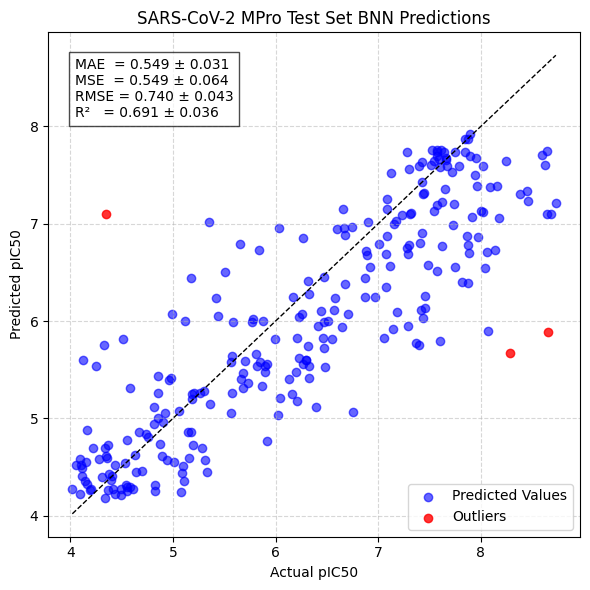

In [20]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# --- Load CSV ---
df = pd.read_csv("SARS_predictions_BNN.csv")

y_true = df["pIC50 (SARS-CoV-2 Mpro)"].values
y_pred = df["mean_prediction"].values

# --- Metrics ---
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# --- Bootstrapping for error bars ---
def bootstrap_metrics(y_true, y_pred, n_bootstrap=1000, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(y_true)
    mae_list, mse_list, rmse_list, r2_list = [], [], [], []
    
    for _ in range(n_bootstrap):
        idx = rng.choice(n, n, replace=True)
        y_true_bs = y_true[idx]
        y_pred_bs = y_pred[idx]
        
        mae_list.append(mean_absolute_error(y_true_bs, y_pred_bs))
        mse_val = mean_squared_error(y_true_bs, y_pred_bs)
        mse_list.append(mse_val)
        rmse_list.append(np.sqrt(mse_val))
        r2_list.append(r2_score(y_true_bs, y_pred_bs))
    
    return {
        "mae": (np.mean(mae_list), np.std(mae_list)),
        "mse": (np.mean(mse_list), np.std(mse_list)),
        "rmse": (np.mean(rmse_list), np.std(rmse_list)),
        "r2": (np.mean(r2_list), np.std(r2_list))
    }

bootstrap_results = bootstrap_metrics(y_true, y_pred)

print("\nBootstrap Results (mean ± std):")
print(f"MAE  = {bootstrap_results['mae'][0]:.4f} ± {bootstrap_results['mae'][1]:.4f}")
print(f"MSE  = {bootstrap_results['mse'][0]:.4f} ± {bootstrap_results['mse'][1]:.4f}")
print(f"RMSE = {bootstrap_results['rmse'][0]:.4f} ± {bootstrap_results['rmse'][1]:.4f}")
print(f"R²   = {bootstrap_results['r2'][0]:.4f} ± {bootstrap_results['r2'][1]:.4f}")

# --- Outlier detection ---
threshold = 2.5
errors = np.abs(y_true - y_pred)
outlier_mask = errors > threshold

outlier_df = df.loc[outlier_mask]
outlier_df.to_csv("sars_predicted_true_bnn_outliers.csv", index=False)
print(f"Saved {len(outlier_df)} outliers to 'sars_predicted_true_bnn_outliers.csv'")

# --- Plot ---
plt.figure(figsize=(6, 6))

# Inliers (blue)
plt.scatter(y_true[~outlier_mask], y_pred[~outlier_mask], 
            color="blue", alpha=0.6, label="Predicted Values")

# Outliers (red)
plt.scatter(y_true[outlier_mask], y_pred[outlier_mask], 
            color="red", alpha=0.8, label="Outliers")

# Perfect correlation line
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

plt.xlabel("Actual pIC50")
plt.ylabel("Predicted pIC50")
plt.title("SARS-CoV-2 MPro Test Set BNN Predictions")

# Add bootstrap metrics text
metrics_text = (
    f"MAE  = {bootstrap_results['mae'][0]:.3f} ± {bootstrap_results['mae'][1]:.3f}\n"
    f"MSE  = {bootstrap_results['mse'][0]:.3f} ± {bootstrap_results['mse'][1]:.3f}\n"
    f"RMSE = {bootstrap_results['rmse'][0]:.3f} ± {bootstrap_results['rmse'][1]:.3f}\n"
    f"R²   = {bootstrap_results['r2'][0]:.3f} ± {bootstrap_results['r2'][1]:.3f}"
)
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(facecolor="white", alpha=0.7))

plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("sars_bnn_test_pred_boot.pdf")
plt.show()
